
# Introduction

In [1]:
import sys
import os
import math
from matplotlib.lines import Line2D
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import geodatasets
import geopandas as gpd
import re
import folium
from folium import plugins
import earthpy as et
import webbrowser
from matplotlib.colors import LogNorm, Normalize
from matplotlib.cm import get_cmap
from branca.colormap import LinearColormap
import statsmodels.api as sm
from geopy.distance import geodesic
from scipy.stats import norm
import elevation
import shapely.geometry
from shapely.geometry import Point, box, Polygon, MultiPolygon
import seaborn as sns
from shapely.wkt import loads
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go
import plotly.io as pio
import plotly.express as px
import rasterio
from rasterio.plot import show
from rasterio.warp import reproject, Resampling, calculate_default_transform
from rasterio.transform import from_bounds, from_origin
from rasterio.mask import mask
import earthpy.spatial as es
from scipy.interpolate import RegularGridInterpolator
from matplotlib.backends.backend_pdf import PdfPages
import streamlit as st
import matplotlib.colors as mcolors
import PyCO2SYS as cs


In [2]:
df = pd.read_excel('/Users/enrico/Desktop/Part III Project/Code/Nepal-1/Datasets/NMS_Copy_080125.xlsx', sheet_name='Final_compiled')

df_abra = pd.read_excel('/Users/enrico/Desktop/Part III Project/Code/Nepal-1/Datasets/Abra.xlsx', sheet_name='Sheet1')

df_copy = df.copy()


In [3]:
df_rain = df[df['Sample type'] == 'Rain']    

#print(df_rain['Sample ID'])

In [4]:
df_copy = df_copy[df_copy['Sample type'].isin(['Spring', 'Spring water', 'Groundwater'])] 

In [5]:
# Convert concentrations from ppm to mM
df_rain['Ca_mM'] = df_rain['Ca_ppm'] / 40.08
df_rain['Sr_mM'] = df_rain['Sr_ppm'] / 87.62
df_rain['Mg_mM'] = df_rain['Mg_ppm'] / 24.31
df_rain['Si_mM'] = df_rain['Si_ppm'] / 28.09
df_rain['Na_mM'] = df_rain['Na_ppm'] / 22.99
df_rain['Li_mM'] = df_rain['Li_ppm'] / 6.94
df_rain['K_mM'] = df_rain['K_ppm'] / 39.10
df_rain['Al_mM'] = df_rain['Al_ppm'] / 26.98
df_rain['Li_uM'] = df_rain['Li_mM'] * 1000

# Convert Cl from molar to mM
df_rain['Cl_mM'] = df_rain['Cl_molar'] / 1000

# Calculate ion ratios
df_rain['Na/Ca'] = df_rain['Na_mM'] / df_rain['Ca_mM']
df_rain['Ca/Na'] = df_rain['Ca_mM'] / df_rain['Na_mM']
df_rain['Mg/Ca'] = df_rain['Mg_mM'] / df_rain['Ca_mM']
df_rain['Mg/Na'] = df_rain['Mg_mM'] / df_rain['Na_mM']
df_rain['Ca/Sr'] = df_rain['Ca_mM'] / df_rain['Sr_mM']
df_rain['1000xSr/Ca'] = df_rain['Sr_mM'] / df_rain['Ca_mM'] * 1000
df_rain['Si/Ca'] = df_rain['Si_mM'] / df_rain['Ca_mM']

/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_1616/2294557472.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rain['Ca_mM'] = df_rain['Ca_ppm'] / 40.08
/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_1616/2294557472.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rain['Sr_mM'] = df_rain['Sr_ppm'] / 87.62
/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_1616/2294557472.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

In [6]:
# Convert concentrations from ppm to mM
df_copy['Ca_mM'] = df_copy['Ca_ppm'] / 40.08
df_copy['Sr_mM'] = df_copy['Sr_ppm'] / 87.62
df_copy['Mg_mM'] = df_copy['Mg_ppm'] / 24.31
df_copy['Si_mM'] = df_copy['Si_ppm'] / 28.09
df_copy['Na_mM'] = df_copy['Na_ppm'] / 22.99
df_copy['Li_mM'] = df_copy['Li_ppm'] / 6.94
df_copy['K_mM'] = df_copy['K_ppm'] / 39.10
df_copy['Al_mM'] = df_copy['Al_ppm'] / 26.98
df_copy['Li_uM'] = df_copy['Li_mM'] * 1000
# Convert Cl from molar to mM
df_copy['Cl_mM'] = df_copy['Cl_molar'] / 1000

# Calculate ion ratios
df_copy['Na/Ca'] = df_copy['Na_mM'] / df_copy['Ca_mM']
df_copy['Ca/Na'] = df_copy['Ca_mM'] / df_copy['Na_mM']
df_copy['Mg/Ca'] = df_copy['Mg_mM'] / df_copy['Ca_mM']
df_copy['Mg/Na'] = df_copy['Mg_mM'] / df_copy['Na_mM']
df_copy['Ca/Sr'] = df_copy['Ca_mM'] / df_copy['Sr_mM']
df_copy['1000xSr/Ca'] = df_copy['Sr_mM'] / df_copy['Ca_mM'] * 1000
df_copy['Si/Ca'] = df_copy['Si_mM'] / df_copy['Ca_mM']

In [7]:

#filter df_rain to remove NaN values
df_rain = df_rain[df_rain['Cl_mM'].notna()]

#print df_rain Cl_mM and Sample ID next to each other
print(df_rain[['Cl_mM', 'Sample ID']])

#plot these on a folium map:
# Create a map centered on Nepal
m = folium.Map(location=[28.3949, 84.1240], zoom_start=7)

# Add points to the map
for idx, row in df_rain.iterrows():
    folium.Marker(location=[row['Latitude'], row['Longitude']], popup=row['Sample ID']).add_to(m)
    
# Display the map
m.save('map.html')
webbrowser.open('map.html')


        Cl_mM  Sample ID
232  0.010560  Nep24-008
236  0.001369  Nep24-012
254  0.000565  Nep24-030
259  0.001343  Nep24-035
260  0.007334  Nep24-036
261  0.001420  Nep24-037
263  0.028087  NEP24-039
267  0.003551  NEP24-043
268  0.001887  NEP24-044
269  0.003213  NEP24-045
270  0.002858  NEP24-046
271  0.000548  NEP24-047
272  0.003646  NEP24-048
277  0.001485  NEP24-053
278  0.006508  NEP24-054
279  0.000257  NEP24-055
281  0.005841  NEP24-057
282  0.000809  NEP24-058
283  0.032024  NEP24-059
284  0.008690  NEP24-060


True

In [8]:
def assign_traverse(gns):
    if not isinstance(gns, str):  # Handle non-string values
        return None

    # Normalize the GNS by stripping suffixes and quotes
    gns = gns.split('22')[0].split('23')[0].strip("'").strip('"')
    
    # S1 group
    if gns.startswith("S1"):
        if gns in ["S1m", "S1i"]:  # Special cases for Traverse 1*
            return "Traverse 1*"
        return "Traverse 1"
    # S2 group
    elif gns.startswith("S2"):
        return "Traverse 2"
    # S3 group
    elif gns.startswith("S3"):
        if gns in ["S3k", "S3m", "S3u", "S3s", "S3ag", "S3ad"]:  # Special cases for Traverse 4
            return "Traverse 4"
        elif gns in ["S3y", "S3ae"]:  # Special cases for Traverse 3*
            return "Traverse 3*"
        return "Traverse 3"  # Default case for S3
    # S4 group
    elif gns.startswith("S4"):
        if gns in ["S4m", "S4l"]:  # Special cases for Traverse 5*
            return "Traverse 5*"
        return "Traverse 5"
    # Default case for unknown values
    return None



# Apply the function to create the new column
df_copy["Traverse"] = df_copy["GNS"].apply(assign_traverse)




In [9]:
#print(df_rain['Traverse'])  
# print Site A, B, C, D, E sample Ids for df_rain
df_rain_siteA = df_rain[df_rain['Traverse'] == 'Site A']
df_rain_siteB = df_rain[df_rain['Traverse'] == 'Site B']
df_rain_siteC = df_rain[df_rain['Traverse'] == 'Site C']
df_rain_siteD = df_rain[df_rain['Traverse'] == 'Site D']
df_rain_siteE = df_rain[df_rain['Traverse'] == 'Site E']

sites = ['Site A', 'Site B', 'Site C', 'Site D', 'Site E']


In [10]:
element_dict = ['Ca', 'Sr', 'Mg', 'Si', 'Na', 'Li', 'K', 'Al', 'Cl']


# Compute site-specific rain averages
site_means = {}
for site in sites:
    site_rain = df_rain[df_rain['Traverse'] == site]
    if not site_rain.empty:  # Only add sites with data
        site_means[site] = {
            'Cl_mM': site_rain['Cl_mM'].mean(),
            **{f'{element}_mM': site_rain[f'{element}_mM'].mean() for element in element_dict}
        }


In [11]:
# Rain Correction
# Equation is for an element X in the river water:
# X_corrected = X_observed - (Cl_river - Cl_river_star) * (X_rain/Cl_rain)
# Where Cl_river_star = Cl_river - Cl_rain
# Cl_river_star = 0 if Cl_river < Cl_rain


# Basic logic:
# Three Sites: C, D, E
# Calculate closest position of sample in df_copy to the site C, D, or E
# Proceed with the rain correction for each element in the sample, using the closest rain site to the sample
# List an element dictionary
# For each element in the dictionary, calculate the corrected value using the equation above
# Make sure to check if Cl_river < Cl_rain, if so, Cl_river_star = 0
# Add the corrected value to a new column in the df_copy dataframe

In [12]:
# Sites C, D, E
sites = ['Site A', 'Site B', 'Site C', 'Site D', 'Site E']

# Convert ppm to mM and store site-specific rain averages
for element in element_dict:
    df_rain[f'{element}_mM'] = df_rain[f'{element}_ppm'] / {'Ca': 40.08, 'Sr': 87.62, 'Mg': 24.31, 'Si': 28.09, 'Na': 22.99, 'Li': 6.94, 'K': 39.10, 'Al': 26.98, 'Cl': 35.453}[element]

# Compute site-specific rain averages
site_means = {}
for site in sites:
    site_rain = df_rain[df_rain['Traverse'] == site]
    if not site_rain.empty:  # Only add sites with data
        site_means[site] = {
            'Cl_mM': site_rain['Cl_mM'].mean(),
            **{f'{element}_mM': site_rain[f'{element}_mM'].mean() for element in element_dict}
        }


# Define function to calculate the closest rain site
def find_closest_site(row, df_rain):
    sample_coords = (row['Latitude'], row['Longitude'])
    df_rain['Distance'] = df_rain.apply(lambda rain_row: geodesic(sample_coords, (rain_row['Latitude'], rain_row['Longitude'])).kilometers, axis=1)
    closest_site = df_rain.loc[df_rain['Distance'].idxmin(), 'Traverse']
    return closest_site

# Add closest site information to df_copy
df_copy['Closest_Site'] = df_copy.apply(find_closest_site, axis=1, df_rain=df_rain)

# Define function to calculate rain correction
def rain_correction(row, site_means, element_dict):
    closest_site = row['Closest_Site']
    if closest_site not in site_means:
        raise ValueError(f"Closest site '{closest_site}' not found in site_means.")

    site_data = site_means[closest_site]
    corrected_values = {}
    for element in element_dict:
        Cl_river = row['Cl_mM']
        Cl_rain = site_data['Cl_mM']
        X_rain = site_data[f'{element}_mM']

        # Calculate Cl_river_star
        Cl_river_star = max(Cl_river - Cl_rain, 0)

        # Calculate X_corrected
        X_corrected = row[f'{element}_mM'] - (Cl_river - Cl_river_star) * (X_rain / Cl_rain)
        corrected_values[f'{element}_mM_*'] = X_corrected

    return pd.Series(corrected_values)


# Apply rain correction
df_corrected = df_copy.apply(rain_correction, axis=1, site_means=site_means, element_dict=element_dict)

# Merge corrected values back into df_copy
df_copy = pd.concat([df_copy, df_corrected], axis=1)

print(df_copy)

     Sample ID     GNS  Season       Date      Time   Sample type  \
68     NEP22-1   S1a22  Nov_22 2022-10-29  16:30:00  Spring water   
69    NEP22-10  S3ab22  Nov_22 2022-10-31  21:30:00  Spring water   
70    NEP22-11  S3ac22  Nov_22 2022-10-31  09:30:00  Spring water   
71    NEP22-12   S3z22  Nov_22 2022-10-31  10:30:00  Spring water   
72    NEP22-13   S3v22  Nov_22 2022-10-31  15:30:00  Spring water   
..         ...     ...     ...        ...       ...           ...   
288  NEP24-064   S2g24  Sep_24 2024-09-16  12:31:54        Spring   
289  NEP24-065   S2f24  Sep_24 2024-09-16  13:26:04        Spring   
290  NEP24-066   S2e24  Sep_24 2024-09-16  14:08:27        Spring   
291  NEP24-067   S2c24  Sep_24 2024-09-16  15:00:54        Spring   
292  NEP24-068   S2a24  Sep_24 2024-09-16  15:34:44        Spring   

    Repeat_collection                                       Site_details  \
68              MKS24  Side of the road just opposite of hotel after ...   
69               MK

In [13]:
# Order samples by Cl_mM_* in descending order
ordered_samples = df_copy.sort_values('Cl_mM_*', ascending=False)

# Find a valid sample where all required X/Cl ratios can be computed
X_Cl_ratios = {}
for _, sample in ordered_samples.iterrows():
    is_valid = True
    ratios = {}
    for element in element_dict:
        # Check for valid Cl and element_mM_* values
        if sample['Cl_mM_*'] > 0 and not pd.isna(sample[f'{element}_mM_*']):
            ratios[element] = sample[f'{element}_mM_*'] / sample['Cl_mM_*']
        else:
            is_valid = False
            break  # If any value is invalid, skip this sample
    
    if is_valid:
        X_Cl_ratios = ratios
        break  # Stop as soon as a valid sample is found

# If no valid sample is found, raise an error or handle it gracefully
if not X_Cl_ratios:
    raise ValueError("No valid sample found for X/Cl ratio calculation.")

print("X/Cl Ratios:", X_Cl_ratios)

# Define the new correction function
def evaporite_correction(row, element_dict, X_Cl_ratios):
    evaporite_corrected_values = {}
    for element in element_dict:
        # Perform the evaporite correction
        X_corrected = row[f'{element}_mM_*']
        Cl_corrected = row['Cl_mM_*']
        X_evaporite_corrected = X_corrected - (X_Cl_ratios[element] * Cl_corrected)
        evaporite_corrected_values[f'{element}_mM_EC'] = X_evaporite_corrected

    return pd.Series(evaporite_corrected_values)

# Apply the evaporite correction
df_evaporite_corrected = df_copy.apply(evaporite_correction, axis=1, element_dict=element_dict, X_Cl_ratios=X_Cl_ratios)

# Merge evaporite-corrected values back into df_copy
df_copy = pd.concat([df_copy, df_evaporite_corrected], axis=1)


X/Cl Ratios: {'Ca': 0.41735569444323306, 'Sr': 0.0015173814010333803, 'Mg': 0.2918610003523339, 'Si': 0.7021082530031759, 'Na': 0.6975619929339737, 'Li': 4.148506057103098e-05, 'K': 0.1447739947492531, 'Al': 0.0001898854392169677, 'Cl': 1.0}


In [14]:
print(df_copy.columns)

Index(['Sample ID', 'GNS', 'Season', 'Date', 'Time', 'Sample type',
       'Repeat_collection', 'Site_details', 'Traverse', 'Traverse_new',
       ...
       'Cl_mM_*', 'Ca_mM_EC', 'Sr_mM_EC', 'Mg_mM_EC', 'Si_mM_EC', 'Na_mM_EC',
       'Li_mM_EC', 'K_mM_EC', 'Al_mM_EC', 'Cl_mM_EC'],
      dtype='object', length=105)


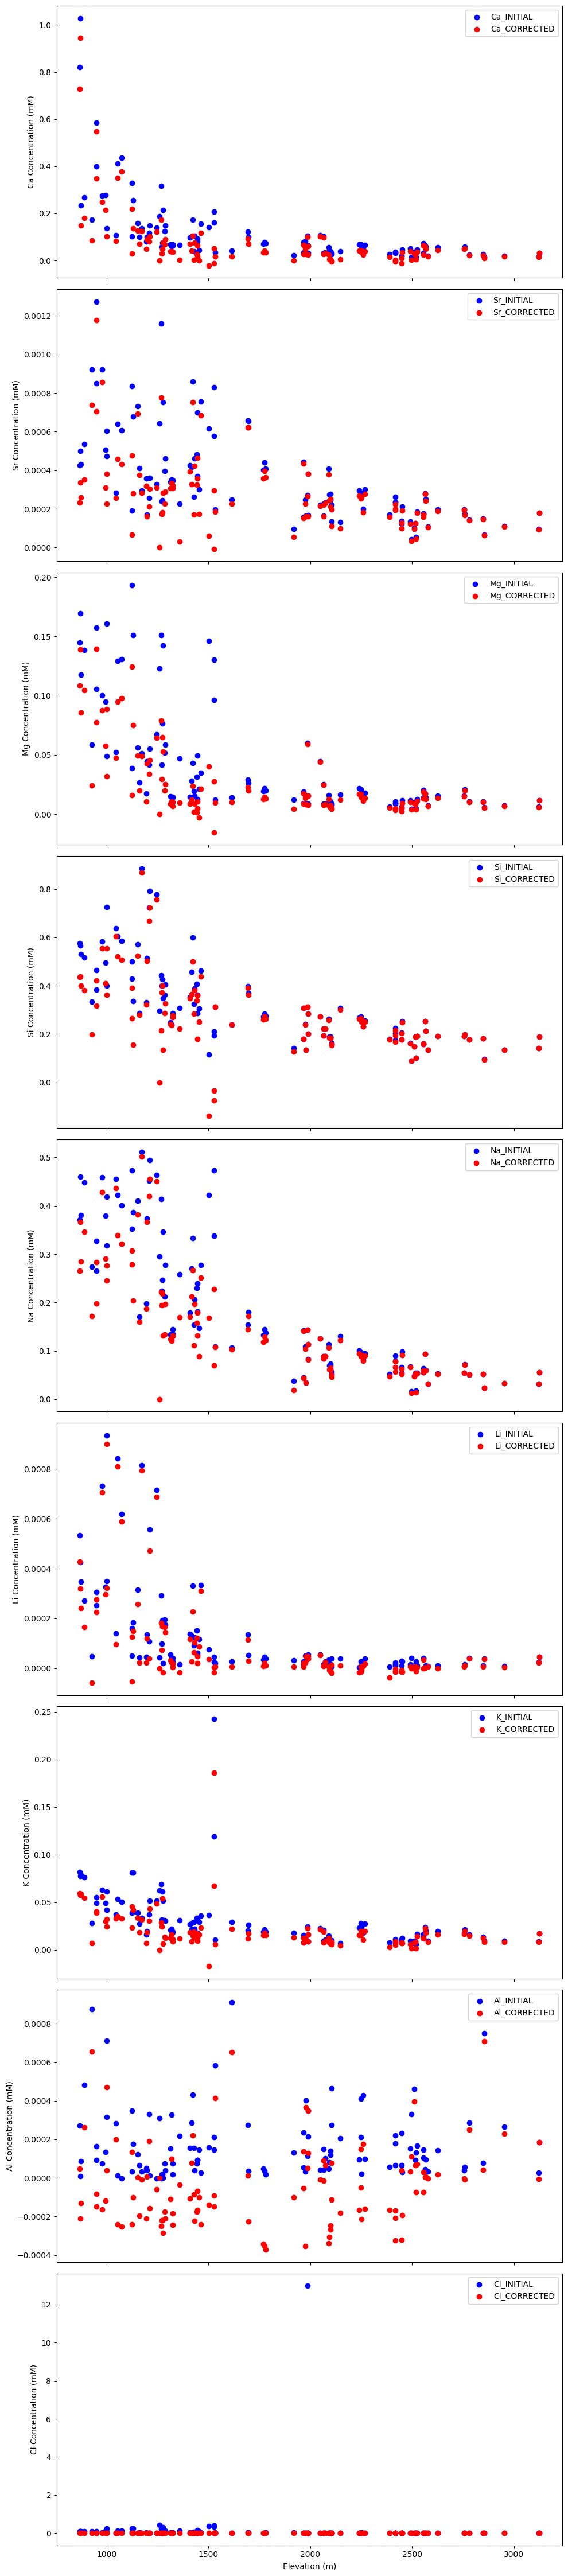

In [15]:

# Filter the DataFrame to include only rows where 'Cl_mM' is not NaN
df_copy = df_copy[df_copy['Cl_molar'].notna()]

# Create a figure and axes for the plots
fig, axs = plt.subplots(len(element_dict), 1, figsize=(10, len(element_dict) * 5), sharex=True)

# Loop through each element and create a scatter plot
for i, element in enumerate(element_dict):
    ax = axs[i]
    ax.scatter(df_copy['Elevation'], df_copy[f'{element}_mM'], label=f'{element}_INITIAL', color='blue')
    ax.scatter(df_copy['Elevation'], df_copy[f'{element}_mM_EC'], label=f'{element}_CORRECTED', color='red')
    ax.set_ylabel(f'{element} Concentration (mM)')
    ax.legend()

# Set the x-axis label for the last subplot
axs[-1].set_xlabel('Elevation (m)')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()
plt.close()

In [16]:
# save df_copy to a new excel file
df_copy.to_excel('Corrected_Spring_Data.xlsx', index=False)

In [17]:

season_colors = {
    'Nov_22': 'blue',
    'Apr_23': 'green',
    'Oct_23': 'red',
    'Sep_24': 'purple'
}

traverse_markers = {
    'Traverse 1': 's',  # Square
    'Traverse 2': 'v',  # Triangle
    'Traverse 3': '*',  # Star
    'Traverse 3*' : '*',  # Star
    'Traverse 4': 'o',   # Circle
    'Traverse 5': 'D',   # Diamond
    'Traverse 5*': 'D'   # Diamond
}

# Define custom colors for traverses
custom_colors = {
    'Traverse 1': '#A385CA',  # Add '#' prefix
    'Traverse 2': '#FDD37E',  
    'Traverse 3': '#9FADDA',  
    'Traverse 3*': '#9FADDA',  
    'Traverse 4': '#1A5AA0',  
    'Traverse 5': '#01316B',  
    'Traverse 5*': '#01316B'  
}

site_markers = {
    'Site A': 'o',  
    'Site B': 'v',
    'Site C': '*',
    'Site D': 's',
    'Site E': 'D',
    'Site F': 'X',
}


tributaries = ['Traverse 1', 'Traverse 2', 'Traverse 3', 'Traverse 3*', 'Traverse 4', 'Traverse 5', 'Traverse 5*']


GNS_markers = {
    'S1': 'o',  
    'S2': 'o',  
    'S3': 'o',  
    'S4': 'o'   
}







# Making the DEM


In [18]:
## ADDING DEM DATA TO THE PLOT
    
dem_path = '/Users/enrico/Desktop/Part III Project/DEM/AP_23217_PLR_F0550_RT1/AP_23217_PLR_F0550_RT1.dem.tif'

    
# Define UTM bounds for Nepal DEM
min_x, min_y, max_x, max_y = 346873.46875, 3078339.0, 362335.96875, 3115539.0


# Define UTM bounds for Nepal DEM
# Set CRS WKT strings
utm_45n_wkt = 'PROJCS["WGS 84 / UTM zone 45N",GEOGCS["WGS 84",DATUM["WGS_1984",' \
            'SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],' \
            'AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],' \
            'UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],' \
            'PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],' \
            'PARAMETER["central_meridian",87],PARAMETER["scale_factor",0.9996],' \
            'PARAMETER["false_easting",500000],PARAMETER["false_northing",0],' \
            'UNIT["metre",1,AUTHORITY["EPSG","9001"]],AUTHORITY["EPSG","32645"]]'

wgs84_wkt = 'GEOGCS["WGS 84",DATUM["WGS_1984",' \
            'SPHEROID["WGS 84",6378137,298.257223563],' \
            'AUTHORITY["EPSG","6326"]],' \
            'PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],' \
            'AUTHORITY["EPSG","4326"]]'

In [19]:
# Open the DEM file and set CRS to UTM Zone 45N if undefined
with rasterio.open(dem_path) as dem_raster:
    src_crs = rasterio.crs.CRS.from_wkt(utm_45n_wkt)  # Using WKT for UTM Zone 45N
    dst_crs = rasterio.crs.CRS.from_wkt(wgs84_wkt)    # Using WKT for WGS84

    # Create a Shapely box with UTM bounds
    dem_box = box(min_x, min_y, max_x, max_y)

    # Mask DEM data to these bounds
    out_image, out_transform = mask(dem_raster, [dem_box], crop=True)
    clipped_dem_array = out_image[0]

    # Calculate transform and reproject to WGS84
    dst_transform, width, height = calculate_default_transform(
        src_crs, dst_crs, clipped_dem_array.shape[1], clipped_dem_array.shape[0], *[min_x, min_y, max_x, max_y]
    )

    dst_array = np.zeros((height, width), dtype=np.float32)
    reproject(
        source=clipped_dem_array,
        destination=dst_array,
        src_transform=out_transform,
        src_crs=src_crs,
        dst_transform=dst_transform,
        dst_crs=dst_crs,
        resampling=Resampling.bilinear
    )

    dst_array[dst_array < 0] = np.nan  # Filter out elevation values below 0

# Define bounds in WGS84 (latitude/longitude) for plotting
bounds = (
    dst_transform.c,  # min longitude
    dst_transform.f + dst_transform.e * height,  # min latitude
    dst_transform.c + dst_transform.a * width,  # max longitude
    dst_transform.f  # max latitude
)


In [20]:
# Generate the x and y coordinates in WGS84
x = np.linspace(bounds[0], bounds[2], dst_array.shape[1])
y = np.linspace(bounds[1], bounds[3], dst_array.shape[0])
x, y = np.meshgrid(x, y)
z = dst_array

# Interpolator for DEM elevations
interpolator = RegularGridInterpolator((y[:, 0], x[0, :]), z, bounds_error=False, fill_value=np.nan)

# Ensure the DataFrame coordinates are in the same CRS as the DEM
df_lons = df_copy['Longitude'].values
df_lats = df_copy['Latitude'].values

# Load the shapefile
shapefile_path1 = "/Users/enrico/Desktop/Part III Project/DEM/Clipped_Shp_Melamchi.shp"
gdf = gpd.read_file(shapefile_path1)



In [21]:
######### IMPORTING DATA FOR GEOLOGY OVERLAY #########

# Load the shapefile
shapefile_path2 = "/Users/enrico/Desktop/Part III Project/QGIS during Fieldwork/geometry5.shp"
gdf2 = gpd.read_file(shapefile_path2)

    

In [22]:
#For Shapefile
    # Define color mapping based on ID
id_to_color = {
    0: 'Blue',
    1: 'Green',
    2: 'Yellow',
    3: 'Orange',
    5: 'Purple',
    }

id_to_label = {
    0: 'Talamarang Formation',
    1: 'Gyalthum Formation',
    2: 'Bolde Quartzite',
    3: 'Timbung Formation',
    5: 'Golphu Formation',
    }

In [23]:
season_colors = {
    'Nov_22': 'blue',
    'Apr_23': 'green',
    'Oct_23': 'red',
    'Sep_24': 'purple'
}

traverse_markers = {
    'Traverse 1': 's',  # Square
    'Traverse 2': 'v',  # Triangle
    'Traverse 3': '*',  # Star
    'Traverse 3*' : '*',  # Star
    'Traverse 4': 'o',   # Circle
    'Traverse 5': 'D',   # Diamond
    'Traverse 5*': 'D'   # Diamond
}


tributaries = ['Traverse 1', 'Traverse 2', 'Traverse 3', 'Traverse 3*', 'Traverse 4', 'Traverse 5', 'Traverse 5*']


GNS_markers = {
    'S1': 'o',  
    'S2': 'o',  
    'S3': 'o',  
    'S4': 'o'   
}





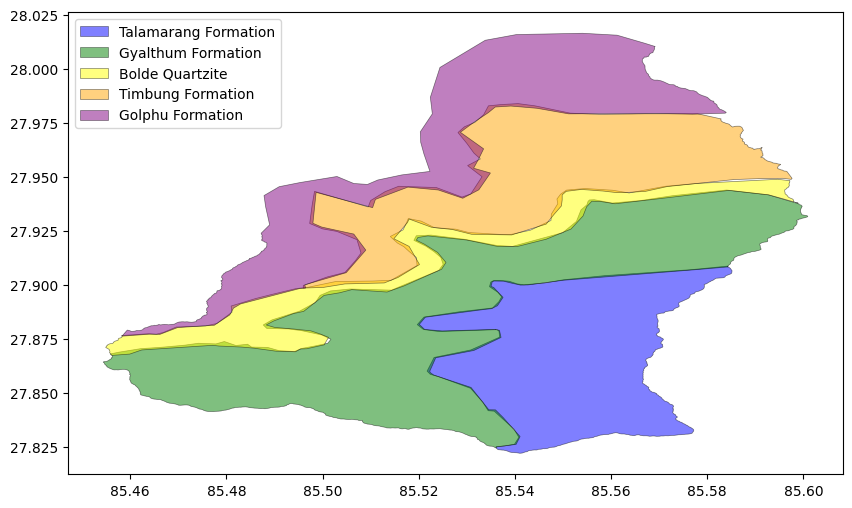

In [24]:
# Define the desired CRS, for example, "EPSG:4326" for WGS 84 or any other projection you need.
desired_crs = "EPSG:4326"

# Reproject the GeoDataFrame to the desired CRS
gdf2 = gdf2.to_crs(desired_crs)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the overlay shapefile with specified colors and labels
plotted_labels = set()  # Keeps track of which labels have been plotted
for geom, id_value in zip(gdf2.geometry, gdf2['id']):
    color = id_to_color.get(id_value, 'grey')  # Default to grey if ID is not in the mapping
    label = id_to_label.get(id_value, '')
    
    if isinstance(geom, Polygon):  # Check if geometry is a Polygon
        x_poly, y_poly = geom.exterior.xy  # Get exterior coordinates
        if label not in plotted_labels:
            ax.fill(x_poly, y_poly, color=color, alpha=0.5, edgecolor='black', linewidth=0.5, label=label)
            plotted_labels.add(label)
        else:
            ax.fill(x_poly, y_poly, color=color, alpha=0.5, edgecolor='black', linewidth=0.5)
    
    elif isinstance(geom, MultiPolygon):  # Check if geometry is a MultiPolygon
        for part in geom.geoms:  # Iterate over constituent polygons
            x_poly, y_poly = part.exterior.xy
            if label not in plotted_labels:
                ax.fill(x_poly, y_poly, color=color, alpha=0.5, edgecolor='black', linewidth=0.5, label=label)
                plotted_labels.add(label)
            else:
                ax.fill(x_poly, y_poly, color=color, alpha=0.5, edgecolor='black', linewidth=0.5)

# Add legend, title, etc., as needed
ax.legend()
plt.show()


# One Traverse Plot

/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_1616/2301712198.py:58: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1.scatter(
/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_1616/2301712198.py:58: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1.scatter(
/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_1616/2301712198.py:58: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1.scatter(
/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_1616/2301712198.py:58: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1.scatter(
/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_1616/2301712198.py:58: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1.scatter(
/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_1616/2

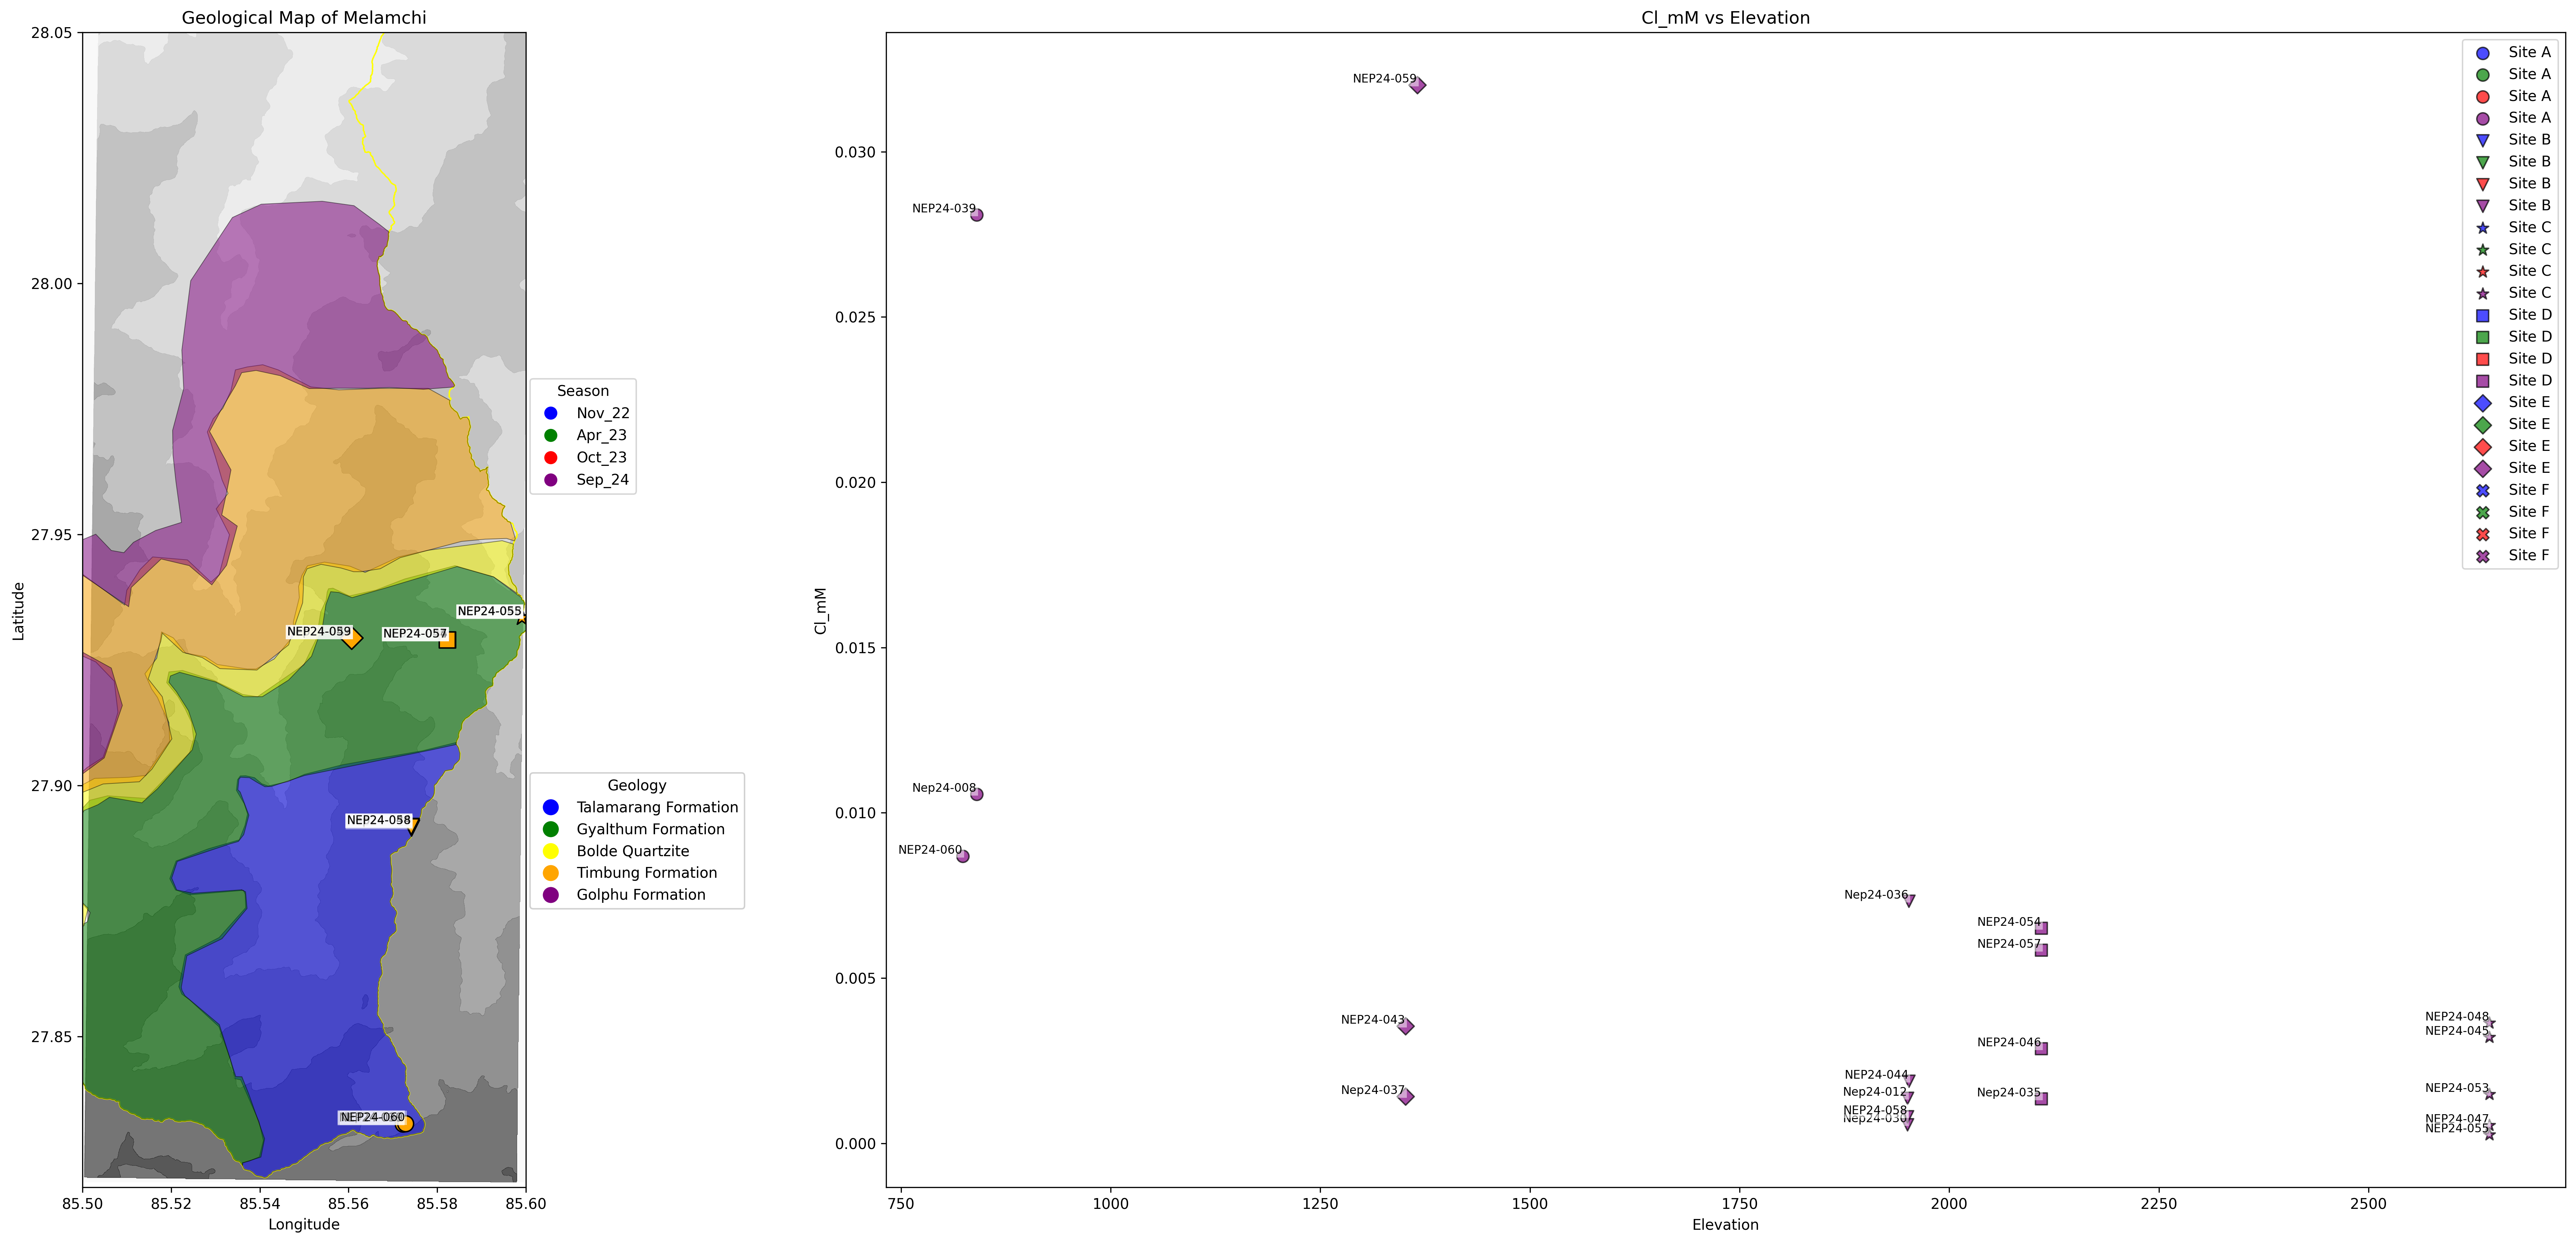

In [25]:

# Create the figure and axes for side-by-side plots
fig, axs = plt.subplots(1, 2, figsize=(30, 12), dpi = 300)

# Define the variables and traverses
variables = ['Cl_mM', 'Elevation']
tributaries = ['Traverse 1', 'Traverse 2', 'Traverse 3', 'Traverse 3*', 'Traverse 4', 'Traverse 5', 'Traverse 5*']

GNS_markers = ['S1', 'S2', 'S3', 'S4']



ax1 = axs[0]
ax2 = axs[1]



# Plot the DEM data in grayscale on ax1
c = ax1.contourf(x, y, z, cmap='Greys', alpha=0.7)


# Overlay the shapefile for watershed boundary
gdf.plot(ax=ax1, facecolor='none', edgecolor='yellow', alpha=1, linewidth=1, label='Melamchi Watershed')

# Overlay gdf2 on ax1 with specified colors and labels
plotted_labels = set()  # Keeps track of which labels have been plotted
geology_handles = []  # Handles for individual geology legend next to ax1
for geom, id_value in zip(gdf2.geometry, gdf2['id']):
    color = id_to_color.get(id_value, 'grey')  # Default to grey if ID is not in the mapping
    label = id_to_label.get(id_value, '')
    
    if isinstance(geom, Polygon):
        x_poly, y_poly = geom.exterior.xy
        ax1.fill(x_poly, y_poly, color=color, alpha=0.5, edgecolor='black', linewidth=0.5)
        if label not in plotted_labels:
            plotted_labels.add(label)
            geology_handles.append(Line2D([0], [0], marker='o', color=color, markersize=10, linestyle='None', label=label))
    elif isinstance(geom, MultiPolygon):
        for part in geom.geoms:
            x_poly, y_poly = part.exterior.xy
            ax1.fill(x_poly, y_poly, color=color, alpha=0.5, edgecolor='black', linewidth=0.5)
            if label not in plotted_labels:
                plotted_labels.add(label)
                geology_handles.append(Line2D([0], [0], marker='o', color=color, markersize=10, linestyle='None', label=label))

cl_min = df_rain[variables[0]].min()
cl_max = df_rain[variables[0]].max()

#filter so that df_copy only contains Sample IDs that start with NEP22:
df_filtered = df_rain.dropna(subset=['Traverse'])

#print(df_filtered['Traverse'])
#df_filtered = df_filtered[df_filtered['Traverse'].str.startswith('Traverse 3')]



for site, marker in site_markers.items():
    site_data = df_filtered[df_filtered['Traverse'] == site]
    ax1.scatter(
        site_data['Longitude'], site_data['Latitude'], s=120, cmap='viridis', alpha=1, 
        edgecolor='k', marker=marker, label=f'{site} - Nep24', color='orange'
    )
    
    # # Add SampleID labels
    for i, row in site_data.iterrows():
        ax1.text(row['Longitude'], row['Latitude'], row['Sample ID'], fontsize=8, ha='right', va='bottom', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', pad=1))
    
# #plot abra samples as red rectangles
# ax1.scatter(df_abra['Longitude'], df_abra['Latitude'], color='red', s=200, alpha=1, edgecolor='k', marker='s', label='Abra Samples')        

# for i, row in df_abra.iterrows():
#     ax1.text(row['Longitude'], row['Latitude'], row['Sample ID'], fontsize=8, ha='right', va='bottom', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', pad=1))


        
        
# Add a colorbar to ax1 using the scatter plot variable `c`
#cbar = plt.colorbar(c, ax=ax1, location='right', pad=0.2)


# Create a legend for the seasons in ax1
season_handles = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=season) 
    for season, color in season_colors.items()
]

# # Set map limits for ax1
ax1.set_xlim(85.5, 85.6)
ax1.set_ylim(27.82, 28.05)

# ax1.set_xlim(85.54, 85.60)
# ax1.set_ylim(27.90, 27.95)


kyul_data = pd.DataFrame({
    'Latitude': [27.932942],
    'Longitude': [85.563408],
    'Label': ['KYUL']
})



thalo_data = pd.DataFrame({
    'Latitude': [27.928879],
    'Longitude': [85.585605],
    'Label': ['THALO']
})

# ax1.scatter(
#     kyul_data['Longitude'], kyul_data['Latitude'],
#     color='red', s=200, alpha=1, edgecolor='k', marker='o', label=kyul_data['Label'][0]
# )

# ax1.scatter(
#     thalo_data['Longitude'], thalo_data['Latitude'],
#     color='blue', s=200, alpha=1, edgecolor='k', marker='o', label=thalo_data['Label'][0]
# )

# BK sampling site: 27.871276N, 85.542173E
bk_data = pd.DataFrame({
    'Latitude': [27.871276],
    'Longitude': [85.542173],
    'Label': ['BK']
})

# ax1.scatter(
#     bk_data['Longitude'], bk_data['Latitude'],
#     color='green', s=200, alpha=1, edgecolor='k', marker='o', label=bk_data['Label'][0]
# )


# Labels and title for ax1
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
#ax1.set_title(f'DEM Map with {variables[1]} Samples for {traverse}')
ax1.set_title('Geological Map of Melamchi')
season_legend = ax1.legend(handles=season_handles, title='Season', loc='upper left', bbox_to_anchor=(1.01, 0.7),
    borderaxespad=0.)

# Place the geology legend to the right of ax1
geology_legend = ax1.legend(
    handles=geology_handles, 
    title='Geology', 
    loc='center left', 
    bbox_to_anchor=(1.01, 0.3),
    borderaxespad=0.
)

# Add both legends to the plot
ax1.add_artist(geology_legend)
ax1.add_artist(season_legend)

for site, marker in site_markers.items():
    
    site_data = df_filtered[df_filtered['Traverse'] == site]

    for season, color in season_colors.items():
        season_data = site_data[site_data['Season'] == season]
        ax2.scatter(
            season_data[variables[1]], season_data[variables[0]], 
            c=color, s=70, alpha=0.7, edgecolor='k', 
            marker=marker, label=site
        )
        for i, row in season_data.iterrows():
             ax2.text(row[variables[1]], row[variables[0]], row['Sample ID'], fontsize=8, ha='right', va='bottom', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', pad=1))


ax2.set_xlabel(f'{variables[1]}')
ax2.set_ylabel(f'{variables[0]}')
#ax2.set_xscale('log')
ax2.set_title(f'{variables[0]} vs {variables[1]}')
ax2.legend()


# Adjust layout and save    
plt.tight_layout()
plt.savefig('Cl_correct.pdf', bbox_inches='tight')
plt.show()
plt.close(fig)

In [26]:
# create a special df with only sites C,D,E on rain_df traverses
df_rain_copy = df_rain.copy()


df_rain_copy = df_rain_copy[df_rain_copy['Traverse'].isin(['Site C', 'Site D', 'Site E'])]

# Filter to remove NEP24-059
df_rain_copy = df_rain_copy[df_rain_copy['Sample ID'] != 'NEP24-059']

In [27]:
df_rain_copy


,Sample ID,GNS,Season,Date,Time,Sample type,Repeat_collection,Site_details,Traverse,Traverse_new,...,Li_mM,K_mM,Al_mM,Li_uM,Cl_mM,Ca/Na,Mg/Na,Ca/Sr,1000xSr/Ca,Distance
259,Nep24-035,NaN,Sep_24,2024-09-10,11:30:48,Rain,NaN,Rain,Site D,Site D,...,0.000032,0.001486,0.000259,0.032421,0.001343,7.784902,0.671246,1388.583456,0.720158,7.738249
261,Nep24-037,NaN,Sep_24,2024-09-10,15:18:10,Rain,NaN,"Rain, sample sitting there 4 nights, very hot....",Site E,Site E,...,0.000025,0.010086,0.000266,0.025072,0.00142,19.352524,6.560072,1098.363456,0.910445,6.928405
267,NEP24-043,NaN,Sep_24,2024-09-12,10:53:50,Rain,NaN,"Kyul rain sample, bottles A & B (comp), 2 nigh...",Site E,Site E,...,0.000013,0.004643,0.000104,0.012968,0.003551,3.539066,0.262274,1381.519303,0.723841,6.928572
269,NEP24-045,NaN,Sep_24,2024-09-12,14:30:45,Rain,NaN,"2 night’s rain at eco lodge. Bottles A&B, no c...",Site C,Site C,...,0.000027,0.001202,0.000068,0.026513,0.003213,1.937995,0.283543,519.547866,1.924750,9.090257
270,NEP24-046,NaN,Sep_24,2024-09-12,14:46:37,Rain,NaN,"12/9 2 nights of rain, two bottles",Site D,Site D,...,0.000028,0.001851,0.000473,0.027522,0.002858,5.395046,0.432842,1458.071585,0.685837,7.737575
271,NEP24-047,NaN,Sep_24,2024-09-12,15:05:07,Rain,NaN,"30min rain event, Samples A&B, no contamination",Site C,Site C,...,0.000050,0.004850,0.000387,0.049568,0.000548,2.945541,0.279813,1001.962652,0.998041,9.090965
272,NEP24-048,NaN,Sep_24,2024-09-12,16:20:26,Rain,NaN,1hr rain event,Site C,Site C,...,0.000039,0.005441,0.000169,0.038617,0.003645,1.237079,0.093615,644.616755,1.551309,9.090712
277,NEP24-053,NaN,Sep_24,2024-09-14,09:30:58,Rain,NaN,Rain sample averaged over 2 nights (of light r...,Site C,Site C,...,0.000032,0.002528,0.000259,0.032277,0.001485,3.523455,0.247332,1043.203998,0.958585,9.090897
278,NEP24-054,NaN,Sep_24,2024-09-14,15:30:59,Rain,NaN,"2 bottles combined, 2 nights of rain",Site D,Site D,...,0.000026,0.002132,0.000568,0.025648,0.006508,7.760277,0.470992,1557.510400,0.642050,7.738300
279,NEP24-055,NaN,Sep_24,2024-09-14,17:15:59,Rain,NaN,NaN,Site C,Site C,...,0.000063,0.007475,0.000223,0.062968,0.000257,4.932989,0.227533,1556.619019,0.642418,9.082619


In [28]:
# average Cl concentration for each site
df_rain_copy.groupby('Traverse')['Cl_mM'].mean()

# Average of all of them
df_rain_copy['Cl_mM'].mean()

np.float64(0.00278796829605393)

# Ion Plots


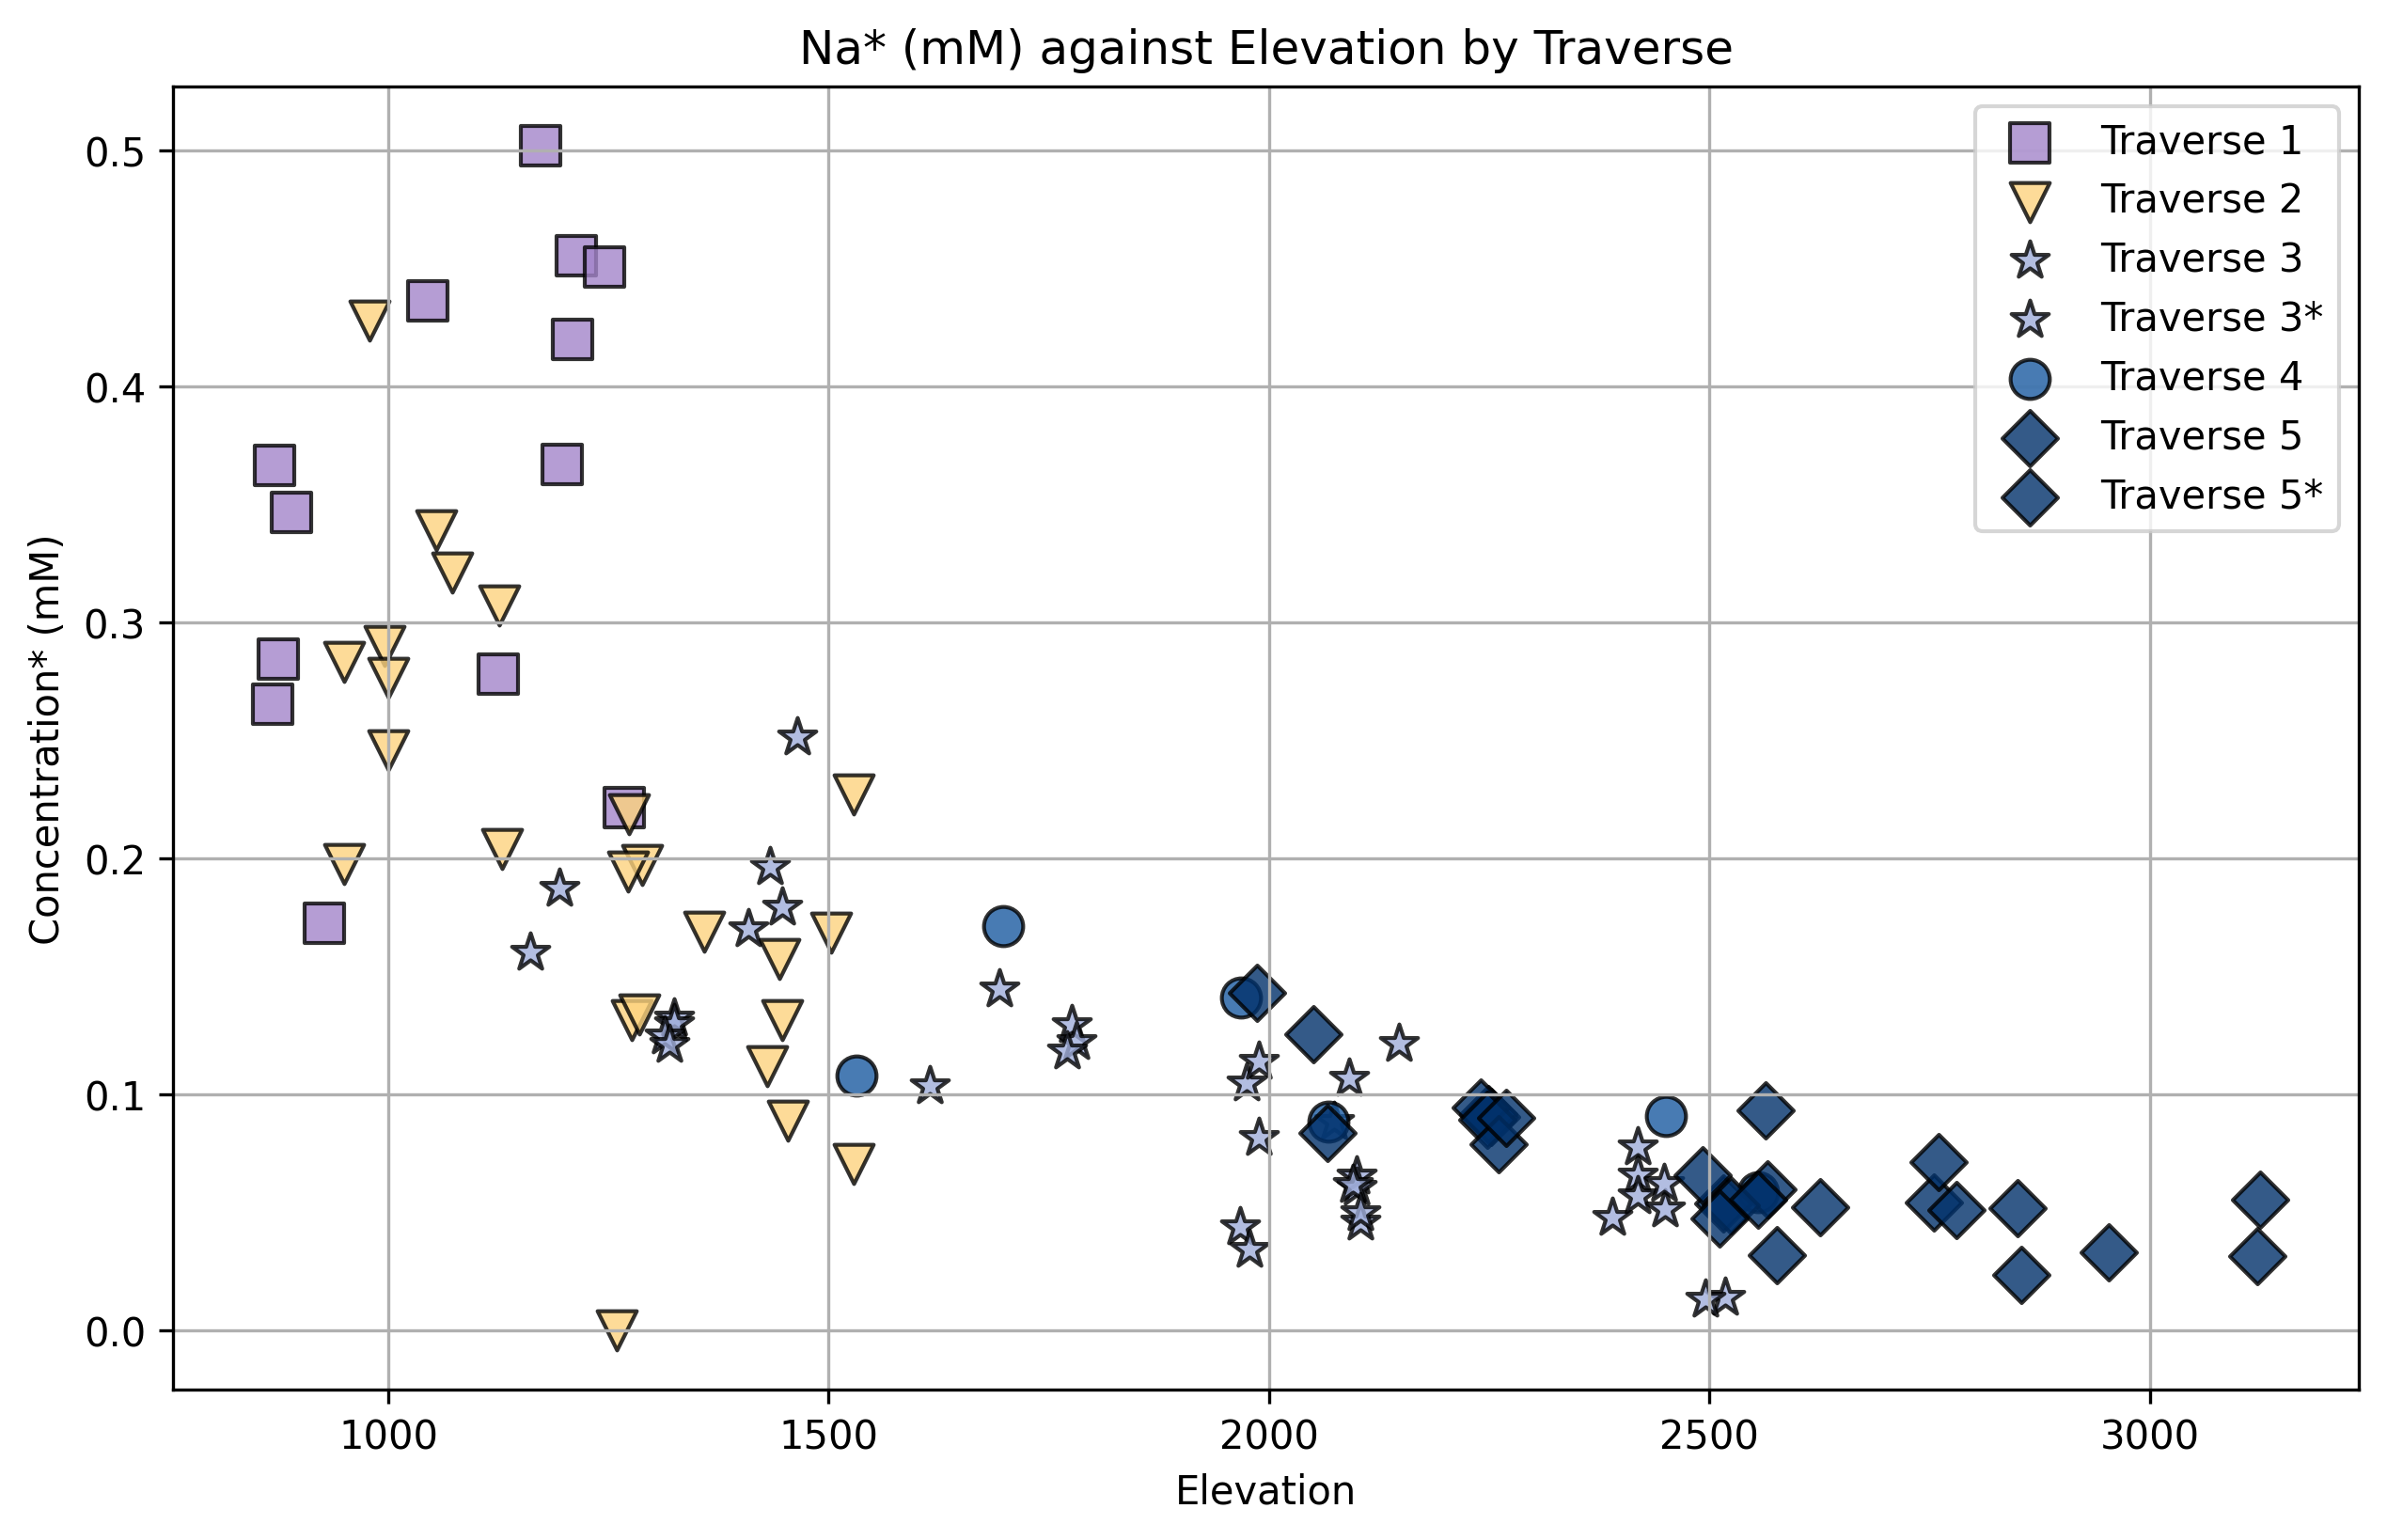

In [29]:
# plot Na and Si mM EC against Elevation coloured by Traverse

import matplotlib.pyplot as plt

# Plot Na and Si (in mM EC) against Elevation, colored by Traverse
plt.figure(figsize=(10, 6), dpi=300)

for traverse, marker in traverse_markers.items():
    # Filter data for the current traverse
    traverse_data = df_copy[df_copy['Traverse'] == traverse]
    
    # Get color for the current traverse
    color = custom_colors.get(traverse, 'black')  # Default to black if color not specified
    
    # Plot Na against Elevation
    plt.scatter(
        traverse_data['Elevation'], traverse_data['Na_mM_EC'], 
        label=f'{traverse}', alpha=0.8, edgecolor='k', 
        marker=marker, s=100, color=color
    )
    
    # # Plot Si against Elevation
    # plt.scatter(
    #     traverse_data['Elevation'], traverse_data['Si_mM_EC'], 
    #     label=f'{traverse} - Si', alpha=0.8, edgecolor='k', 
    #     marker=marker, s=100, color=color, linestyle='dotted'
    # )

# Add plot labels, title, legend, and grid
plt.xlabel('Elevation')
plt.ylabel('Concentration* (mM)')
plt.title('Na* (mM) against Elevation by Traverse')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_1616/3078408405.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traverse_data['Na/Si'] = traverse_data['Na_mM'] / traverse_data['Si_mM']


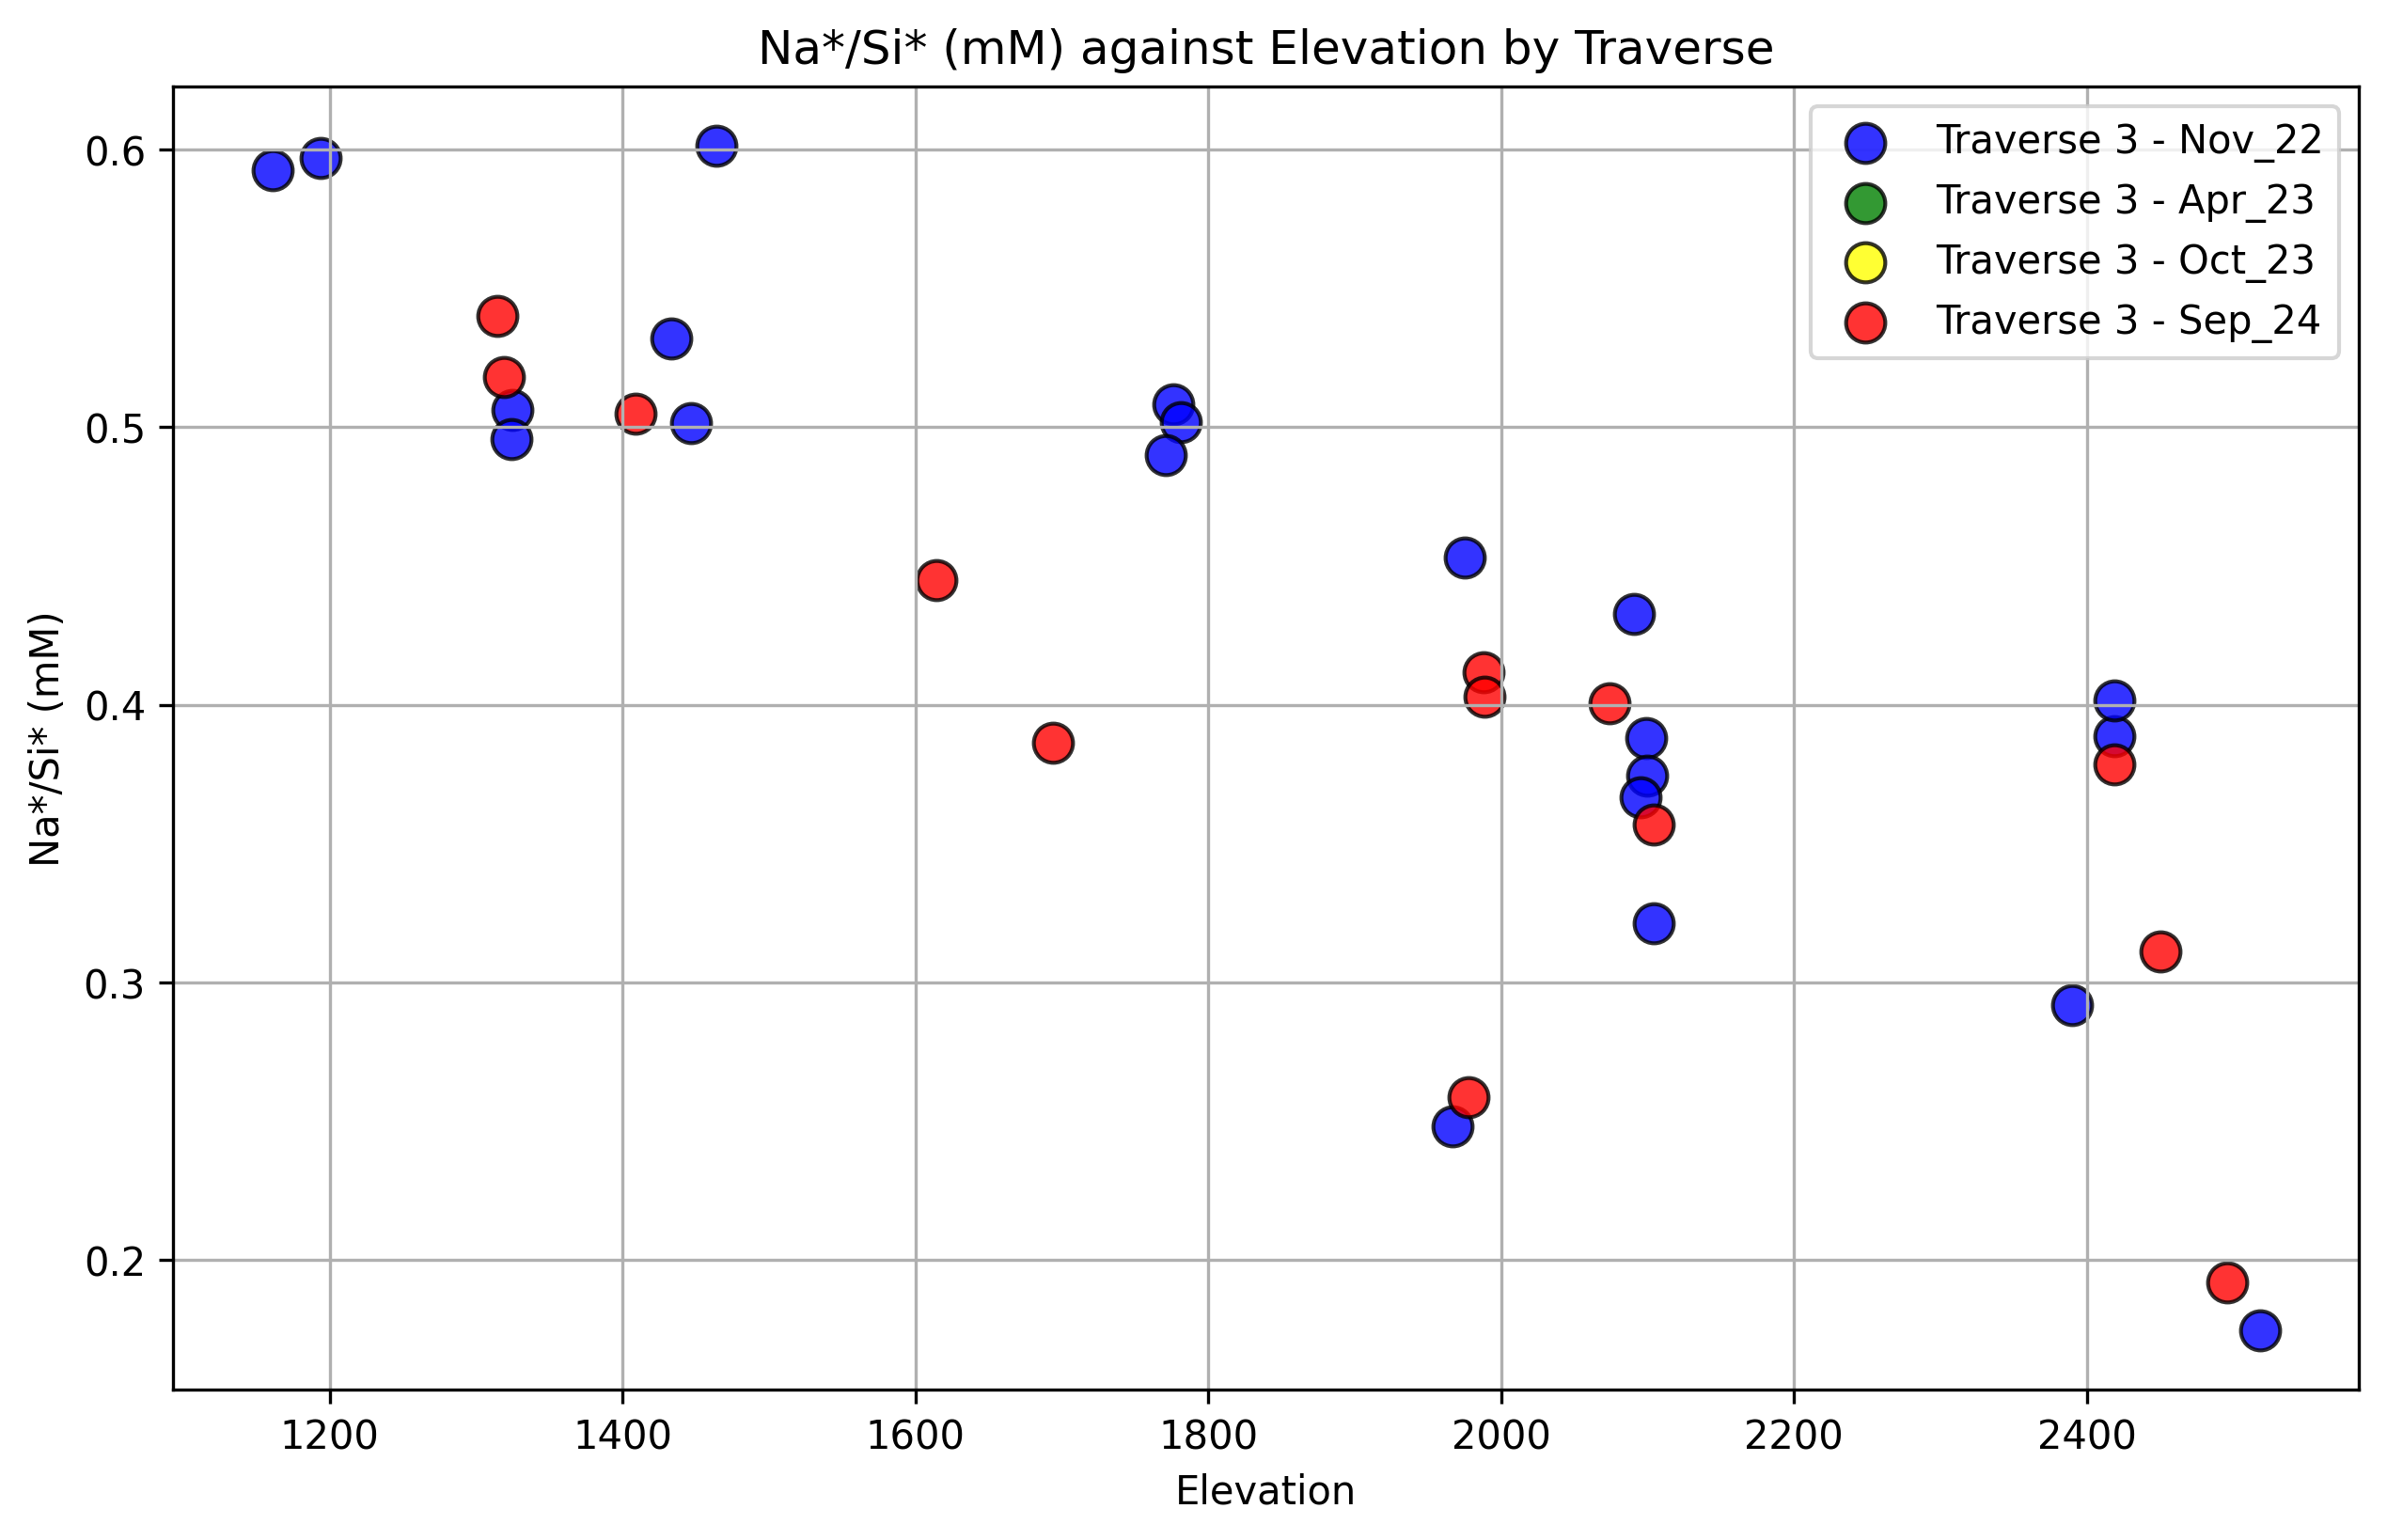

In [30]:
# plot Na and Si mM EC against Elevation coloured by Traverse

# Remove NEP24-061, NEP22-62, NEP22-61
df_copy = df_copy[~df_copy['Sample ID'].isin(['NEP24-061', 'NEP22-62', 'NEP22-61'])]


season_colors = {
    'Nov_22': 'blue',
    'Apr_23': 'green',
    'Oct_23': 'yellow',
    'Sep_24': 'red'
}

# Plot Na and Si (in mM EC) against Elevation, colored by Traverse
plt.figure(figsize=(10, 6), dpi=300)


traverse_data = df_copy[df_copy['Traverse'] == 'Traverse 3']

traverse_data['Na/Si'] = traverse_data['Na_mM'] / traverse_data['Si_mM'] 

# Get color for the current traverse
color = custom_colors.get(traverse, 'black')  # Default to black if color not specified
# Plot Na/Si against Elevation, colored by Season
for season, color in season_colors.items():
    season_data = traverse_data[traverse_data['Season'] == season]
    plt.scatter(
        season_data['Elevation'], season_data['Na/Si'], 
        label=f'Traverse 3 - {season}', alpha=0.8, edgecolor='k', s=100, color=color
    )
    # # Plot Si against Elevation
    # plt.scatter(
    #     traverse_data['Elevation'], traverse_data['Si_mM_EC'], 
    #     label=f'{traverse} - Si', alpha=0.8, edgecolor='k', 
    #     marker=marker, s=100, color=color, linestyle='dotted'
    # )
    
    # for i, row in traverse_data.iterrows():
    #     plt.text(row['Elevation'], row['Na/Si'], row['Sample ID'], fontsize=8, ha='right', va='bottom', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', pad=1))


# Add plot labels, title, legend, and grid
plt.xlabel('Elevation')
plt.ylabel('Na*/Si* (mM)')
plt.title('Na*/Si* (mM) against Elevation by Traverse')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
